# Pipeline
![Pipeline](./foto/pipeline2.jpg)
This pipline is presented in the notebook.
1. **Data Collection**: This is already done and the samples can be found in the database.
2. **Data Preperation**: Before the data can be passed to the model, we have to prepare the data. The html files need to be parse because they are too large for the LLM. Beside that not every model can work with images, so for some models we have to convert the screenshots to text. To achieve a decent performance, we need to find a good format for the prompts.
3. **Generator Model**: Here we need to select a fitting model. In this notebook, we present the LLaVA model which accepts images and text. We will input the use case, the html code and one screenshot. The model should create playwright code based on this input.
4. **Finetuning**: The basic model will probably not perform good on the given task, so we need to finetune it using our collected data.
5. **Validation Model**: For automatic validation of the output of the first model, we will use a second model. It receives the expect-functions of the first model and a screenshot of the website after running the generated playwright code as input. The it will output 1 (the expect function is fullfilled in the screenshot) or 0 (the expect function is fullfilled).
6. To optimize the performance, we might go back to the previous steps and optimize the models and prompts.

# Model Selection

LLaVA is a state-of-the-art approach for integrating linguistic and visual data. Unlike traditional models that focus primarily on text or image processing, LLaVA stands out for its ability to seamlessly integrate these two domains. This enables the model to understand and interpret the intricate relationships between visual elements and textual descriptions, leading to more nuanced and contextually rich AI interactions.
![Llava architecture](./foto/llava.png)

You find more information about the LLaVA model on [Github](https://github.com/haotian-liu/LLaVA)

# Setup SDIL
The size of the model requires us to train on a server with powerful GPUs. Here is a short decription for the setup of the server and how to solve common issues.

## Login
- Login to
server
```
ssh username@uc2.scc.kit.edu
```
- or jupyter hub with :
```
https://sdil-jupyter.scc.kit.edu
```
- Use your given SDIL account.
- Requires you to be in the KIT-Network.
- When using jupyter hub, select 1 GPU and your required runtime.

## Add a User
1. Visit the KIT [Tokenmanager](https://my.scc.kit.edu/token/index.php#/user-detail) using the given SDIL account.
2. Create a new Smartphone-token.
3. The new user needs to scan the QR-code using the Google Authenticator App.
4. When logging in for the first time in Jupyter, the new user needs to input the current token created by the Google Authenticator App.

## Prepare the Environment
If you have problems with the installation read the notes below.

1. Clone llava into :
```
git clone https://github.com/haotian-liu/LLaVA.git
cd LLaVA
```
2. Create a new environment:
```
conda create -n llava python=3.10 -y
conda activate llava
```
4. Install the following packages (when using the second command, you need to be in the LLaVA folder):
```
pip install --upgrade pip  # enable PEP 660 support
pip install -e .
pip install -e ".[train]"
pip install flash-attn --no-build-isolation
```
When you have problems with the last step go [here](https://github.com/Dao-AILab/flash-attention/releases/tag/v2.5.8) and download the fitting whl-file for your cuda (cu), pytorch (torch) and python (cp) version. Then upload it to your current directory and install it manually with:
```
pip install flash_attn-2.5.8+cu...
```

5. If you want to use the enviroment with a notebook set up ipykernel:
```
pip install ipykernel

```

7. Upload finetune data
- to server with scp in the terminal:
```
scp -r data hj7422@uc2.scc.kit.edu:/pfs/data5/home/kit/tm/hj7422/2024_sdil_multinode_finetuning/finetune_pw
```
- or per drag and drop to jupyter hub

# Important Notes

## Modules
When you have issues connecting to a kernel in the notebook, installing packages or imports, make sure you only have loaded cuda12.2 in the "Softwares"-tab. Then restart your notebooks and terminals.

![Unload the modules](./foto/unload_modules.png)

## Issues with Imports
When you have errors from imports after the installation of llava. Perform the following commands in your environment:
```
pip uninstall flash-attn
pip install flash-attn --no-build-isolation --no-cache-dir
```

## General Issues
If you have any other problems have a look in the [LLaVA Github](https://github.com/haotian-liu/LLaVA/issues?q=).

# Data Preparation

For the llava model finetuning we need the following format:
```
[
    {
        "id": "unique_id",
        "image": "image_file.jpg",
        "conversations": [
            {
    
                "from": "human",
                "value": "What is shown in the image?"
    
            },
            {
                "from": "gpt",
                "value": "formatted_answers"
            }
        ]
    }
 
]

```
we can see that, for each item we need:
- unique id
- image path
- input text (promp)
- output text

The questions and answers are formatted into a single JSON file. In this structure, the 'human' key represents the person asking the question, and the 'gpt' key represents LLaVA's response. The JSON format is crucial as it matches the expected input format for LLaVA, enabling effective training and fine-tuning of the model.

# Extract data from database

In [1]:
import sqlite3
# Connect to the database
conn = sqlite3.connect('./data/playwright_script.db')
cursor = conn.cursor()

res = cursor.execute("SELECT * FROM tests")
items = res.fetchall()

print( "there are {} data.".format(len(items)))

there are 100 data.


In [2]:
res = cursor.execute("SELECT * FROM tests")
items = res.fetchall()
conn.close()
items

[('1.1',
  '[1.1] Öffne die Arbeitsmappe "Übersicht Messstellen" im Ordner "Gewässergüte".',
  '[1.1] Expected result: Die Arbeitsmappe wird geöffnet, der Analysekontext ist nicht sichtbar.',
  '.\\html\\1_1.html',
  '.\\screenshot\\1_1.png',
  '.\\test_script\\1_1.spec.ts'),
 ('1.2',
  '[1.1] Öffne die Arbeitsmappe "Übersicht Messstellen" im Ordner "Gewässergüte". [1.2]  Öffnen der Tabellen-Sicht "Messstellenliste" über die Werkzeugliste der Arbeitsmappe.',
  '[1.2] Expected result: Die Tabelle "Messstelleninformationen" wird angezeigt, der Analysekontext ist sichtbar.',
  '.\\html\\1_2.html',
  '.\\screenshot\\1_2.png',
  '.\\test_script\\1_2.spec.ts'),
 ('1.3',
  '[1.1] Öffne die Arbeitsmappe "Übersicht Messstellen" im Ordner "Gewässergüte". [1.2]  Öffnen der Tabellen-Sicht "Messstellenliste" über die Werkzeugliste der Arbeitsmappe. [1.3] Klicke auf den 3-Punkte-Button innerhalb der Tabellen-Sicht "Messstelleninformationen"',
  '[1.3] Expected result: Kontextmenü erscheint mit den O

Each test is named using a two-part numerical format, represented as `{x}.{y}`, where:

- `x` is the unique identifier for a set of UI tests.
- `y` indicates the step number within the UI test sequence, facilitating the tracking of test progress and specific actions.

Each UI test entry comprises six essential elements to ensure completeness and executability:

1. **ID**: Formatted as `x`.`y`, uniquely identifies each test and the step.
2. **Step Description**: Details the actions performed at each step, always starting from the first step.
3. **Expected Outcome**: Describes the expected result of the final step of the test.
4. **HTML File**: The HTML file generated after all actions have been executed, used for further analysis and review.
5. **Screenshot**: An image of the application or software interface taken after all actions have been completed, used for visual verification.
6. **Script**: Contains the Playwright code from the first to the last step, used to automate the UI test.

Considering that the goal of the model is to generate playwright code based on screenshots, html, and step-by-step instructions, the screenshots and html information for each item in the database are from the execution of the corresponding action. In addition, the script corresponding to each item is the complete process from the initial state to the current state. In order to get all the information we need for the target format, we should do the following.

1. Get the screenshot and html of the preconditions of each step by their IDs
2. Extract the HTML information
3. Generate hints by combining the text description and the extracted html information.
4. Generate the target script by comparing the preconditions with the current state script.

In the following there are some key points to note in this process.

## HTML Infomation Extration
When looking at the HTML-files, we can see that only one consists of thousands of charaters. Since the locators of Playwright only require the information of a few attributes there is a lot useless information in the html-files. For several reasons it is imporant to focus on the relavant information when working with LLMs:

- **Data Efficiency**: LLMs are trained on vast amounts of data, and their performance heavily relies on the quality and relevance of the input data. By feeding the model only the relevant code information, you reduce noise and irrelevant details that could distract the model or hinder its ability to identify patterns and make accurate predictions.
- **Reducing Training Time**: Irrelevant code information can slow down the training process as the model has to process and filter out unnecessary data. By providing only the relevant code information, training time can be reduced, enabling faster iterations and improvements in the model's performance.
- **Avoiding Overfitting**: Overfitting occurs when a model memorizes training data instead of learning underlying patterns. By excluding irrelevant information, you reduce the risk of overfitting, ensuring that the LLM learns to generalize effectively and perform well on a wider range of coding tasks.
- **Enhancing Generalization**: LLMs aim to generalize learned patterns to new and unseen scenarios. By training the model on relevant information, it becomes better at recognizing and adapting to variations and nuances within coding tasks. This improves the model's ability to generalize, leading to more robust and adaptable performance.

## Prompt Engineering
Prompt engineering is a crucial technique for optimizing the performance of language models. There are several reasons why prompt engineering is important:
- **Improving Performance**: Well-engineered prompts can enhance the performance of language models by influencing them to generate more accurate, relevant, and creative outputs. This is especially beneficial for large language models (LLMs) that are capable of handling complex tasks.
- **Enhancing Control**: Prompt engineering ensures that the most generated content closely matches the user’s needs and expectations.

In [3]:
from pathlib import Path
import json
import os

def db_query(sql_query, params=None):
    conn = sqlite3.connect('./data/playwright_script.db')
    cursor = conn.cursor()
    if params:
        cursor.execute(sql_query, params)
    else:
        cursor.execute(sql_query)
    results = cursor.fetchall()
    conn.commit()
    conn.close()
    return results


1. Connects to the specified SQLite database.
2. Executes a given SQL query with optional parameters.
3. Fetches all results from the query.
4. Commits any changes (if applicable).
5. Closes the database connection.
6. Returns the fetched results.

In [4]:
def extract_html_information(html_path):
    # naive solution
    with open(html_path, 'r', encoding='ISO-8859-1') as file:
        html_content = file.read()
    return html_content[:20]

This code reads the content of an HTML file located at html_path, assuming it's encoded in ISO-8859-1 encoding. It then returns the first 20 characters of this HTML content. This function provides a naive way to quickly extract a snippet of text from an HTML file for further processing or analysis.

In [5]:
def path_fix(path):
    return os.path.normpath(path).replace('\\', '/')
    
def extract_extra_operations(script1_path, script2_path):
    # read scripts
    with open(script1_path, 'r', encoding='ISO-8859-1') as f1:
        script1_lines = f1.readlines()
        
    with open(script2_path, 'r', encoding='ISO-8859-1') as f2:
        script2_lines = f2.readlines()

    script1_lines = [line.strip() for line in script1_lines if line.strip()]
    script2_lines = [line.strip() for line in script2_lines if line.strip()]

    # local extrat part
    extra_operations = '\n'.join([line for line in script2_lines if line not in script1_lines])

    return extra_operations

This function compares two scripts to identify lines in script2_path that are not present in script1_path. It eliminates the parts of the type script that are only preconditions.

In [6]:
def prompt_engineering(steps, html):
    # naive solution
    prompt = f'Write type script code using the playwrite library to test the components discribed in the use case. \n USE-CASE: {steps}'
    
    return prompt

This is a naive way of a prompt where we only consider the use case with html code. Modify this to optimize the performance.

In [7]:
def convert_db_item_to_json_dict(uid, idn, prefix='./'):
    # placeholder
    steps = None
    script = None
    screenshot_pre = None
    html_pre = None
    script_pre = None
    
    # get item with id
    x, y = idn.split('.')
    items = db_query(f"SELECT * FROM tests WHERE ID==?", (f'{x}.{y}',))
    if len(items) == 0:
        print("Error: target test case not found!")
        return -1
    item = items[0]
    steps = item[1]
    script = path_fix(prefix + item[5])
    
    # load precondition information
    if y == '1':
        # it's first step in the uitest
        screenshot_pre = '0_1.png'#prefix + 'screenshot\\0_1.png'
        html_pre = path_fix(prefix + 'html\\0_1.html')
        script_pre = path_fix(prefix + 'test_script\\0_1.spec.ts')
    else:
        items_pre = db_query(f"SELECT * FROM tests WHERE ID==?", (f'{x}.{str(int(y)-1)}',))
        if len(items_pre) == 0:
            print("Error: precondition item not found!")
            return -1
        item_pre = items_pre[0]
        html_pre = path_fix(prefix + item_pre[3])
        screenshot_pre = path_fix(prefix + path_fix(item_pre[4])).split('/')[-1]
        script_pre = path_fix(prefix + item_pre[5])
    
    # extract information from html
    html_pre = extract_html_information(html_pre)
    
    # prompt engineering
    inp = prompt_engineering(steps, html_pre)

    # compare the scripts
    script = extract_extra_operations(script_pre, script)
    
    # generate json dict
    json_data = {
                "id": uid,
                "image": screenshot_pre,
                "conversations": [
                    {
                        "from": "human",
                        "value": inp
                    },
                    {
                        "from": "gpt",
                        "value": script
                    }
                ]
            }
    
    return json_data

This function integrates data retrieval from the database, preprocesses the HTML code, use case, plawright code and JSON serialization. It aims to encapsulate and transform database entries into a structured JSON format suitable for the LLM.

In [8]:
from tqdm import tqdm

# extract data from db and convert to json file
ids = [i[0] for i in db_query(f"SELECT * FROM tests")]

prefix = './data/'
json_output_path_train = './data/finetune/dataset.json'
json_data_list_train = []
for uid, idn in tqdm(enumerate(ids)):
    json_data_train = convert_db_item_to_json_dict(uid, idn, prefix)
    json_data_list_train.append(json_data_train)
        
with open(path_fix(json_output_path_train), 'w') as json_file:
    json.dump(json_data_list_train, json_file, indent=4)


100it [00:00, 419.02it/s]


In [1]:
import json
from pathlib import Path
json_file_path = Path('./data/finetune/dataset.json')

with json_file_path.open('r', encoding='utf-8') as file:
    data = json.load(file)

data

[{'id': 0,
  'image': '0_1.png',
  'conversations': [{'from': 'human',
    'value': 'Write type script code using the playwrite library to test the components discribed in the use case. \n USE-CASE: [1.1] Öffne die Arbeitsmappe "Übersicht Messstellen" im Ordner "Gewässergüte".'},
   {'from': 'gpt',
    'value': "await page.getByText('Verzeichnis GewÃ¤ssergÃ¼te', { exact: true }).click();\nconst parentElement = await page.getByText('Arbeitsmappe Ã\x9cbersicht Messstellen').locator('..');\nawait parentElement.locator('.d-icon.d-icon-bold.status-icon').click();"}]},
 {'id': 1,
  'image': '1_1.png',
  'conversations': [{'from': 'human',
    'value': 'Write type script code using the playwrite library to test the components discribed in the use case. \n USE-CASE: [1.1] Öffne die Arbeitsmappe "Übersicht Messstellen" im Ordner "Gewässergüte". [1.2]  Öffnen der Tabellen-Sicht "Messstellenliste" über die Werkzeugliste der Arbeitsmappe.'},
   {'from': 'gpt',
    'value': "await page.getByRole('l

Now we load the created json file which includes all relevant attribute for the model input.

# Using the Model
## Code Generation
First, we want to use the model to generate playwright code for us.

In [2]:
from PIL import Image
# use case
prompt = data[0]['conversations'][0]['value']
print(prompt)


Write type script code using the playwrite library to test the components discribed in the use case. 
 USE-CASE: [1.1] Öffne die Arbeitsmappe "Übersicht Messstellen" im Ordner "Gewässergüte".


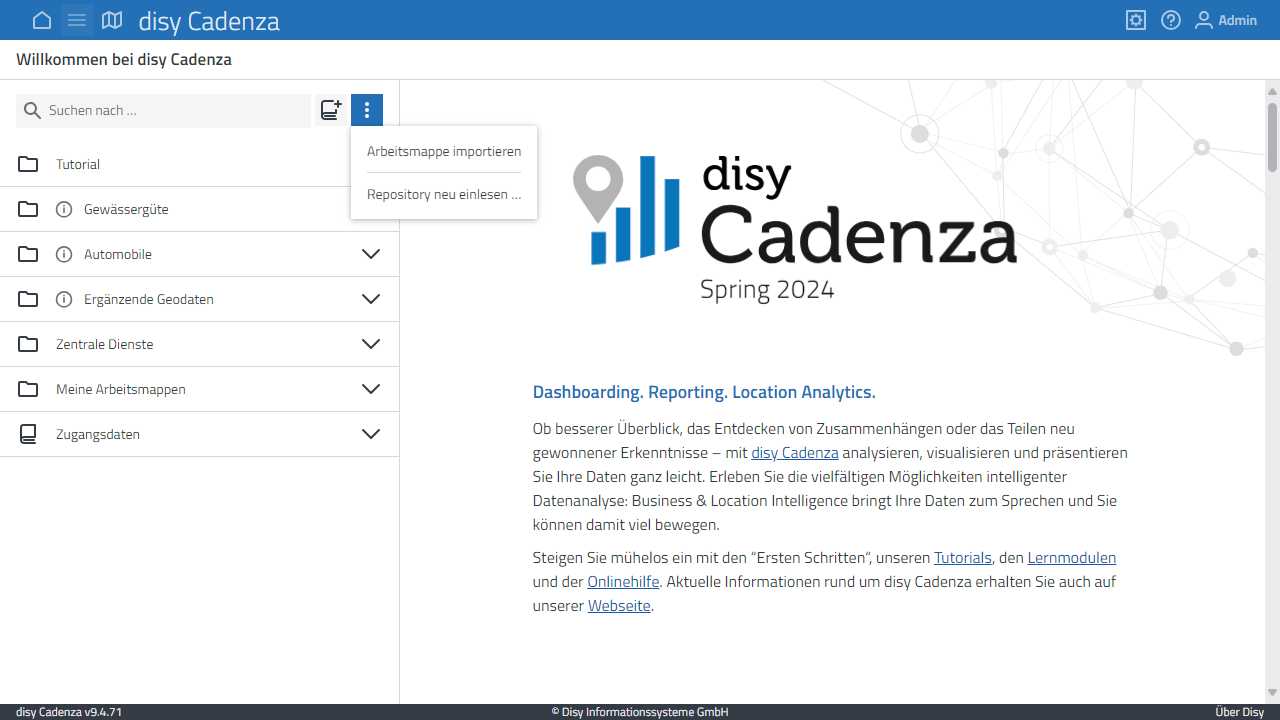

In [3]:

# image
image_file = data[0]['image']
image_path = f'./data/screenshot/{image_file}'
try:
    with Image.open(image_path) as img:
        display(img)
except IOError:
    print("Unable to load image")

In [4]:
# type script
script = data[0]['conversations'][1]['value']
print(script)

await page.getByText('Verzeichnis GewÃ¤ssergÃ¼te', { exact: true }).click();
const parentElement = await page.getByText('Arbeitsmappe Ãbersicht Messstellen').locator('..');
await parentElement.locator('.d-icon.d-icon-bold.status-icon').click();


First, we select a sample that we want to put into the model. This are the promt, ts-code and screenshot that we want to use. The ts-code will be later the target in the training.

In [5]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

/pfs/work7/workspace/scratch/hj7422-cadenzaws/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-07-01 00:54:19,267] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [9]:
model_path = "liuhaotian/llava-v1.6-vicuna-7b"
prompt2 = "Describe the elements and their positions of this website as detailed as possible."

args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt2,
    "conv_mode": None,
    "image_file": image_path,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

eval_model(args)

/pfs/work7/workspace/scratch/hj7422-cadenzaws/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/pfs/work7/workspace/scratch/hj7422-cadenzaws/llava/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 3/3 [00:24<00:00,  8.04s/it]
/pfs/work7/w

The image shows a screenshot of a website interface, specifically the homepage of a service called "disy Cadena." The website is designed with a clean and modern aesthetic, featuring a color scheme that includes shades of blue and white.

At the top of the page, there is a navigation bar with the following elements:

1. A logo on the left side, which appears to be the company's name "disy Cadena" in lowercase letters.
2. A search bar with a placeholder text "Willkommen bei disy Cadena" which translates to "Welcome to disy Cadena" in English.
3. A menu icon on the left side, suggesting a dropdown menu with various options such as "Tutorial," "Gewissheit," "Automobil," "Erinnert," "Zentrale Dienste," and "Meine Aufgaben."
4. A user profile icon on the right side, indicating a user's profile or settings.
5. A "Logout" button on the right side, suggesting the user can log out from the system.

Below the navigation bar, there is a large banner with the text "disy Cadena" in bold, uppercase 

In [10]:
prompt = data[0]['conversations'][0]['value']

args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_path,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

eval_model(args)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


To test the components described in the use case, you would need to write TypeScript code using the Playwright library. Below is an example of how you might structure the code to open the "Übersicht Messstellen" file in the "Gewässergüte" folder:

```typescript
import { chromium } from 'playwright';

async function openWorkspace() {
  const browser = await chromium.launch();
  const context = await browser.newContext();
  const page = await context.newPage();

  // Navigate to the folder containing the "Gewässergüte" folder
  await page.goto('path/to/your/folder');

  // Wait for the "Übersicht Messstellen" file to load
  await page.waitForSelector('path/to/your/file.html');

  // Once the file is loaded, you can interact with it as needed
  // For example, you might click on buttons, fill out forms, or interact with the content

  // Close the browser when you're done
  await browser.close();
}

// Call the function to open the workspace
openWorkspace();
```

Please replace `'path/to/

We can see that currently the model creates some playwright code but it does not work very well. There are several issues:
- It created mulitiple tests
- It does not include the html files
- It contains unnecessary information

So we need to finetune this model for our projekt

## Validation
As mentioned, we want to use a (another) model to validate the output of the first model. 

TODO add validation model

# Finetuning

Now that the dataset is formatted and ready, we will move on to the training phase of LLaVA. We will use the original LLAVa database as a base.
The process of finetuning will take a few hours, so we recommend to submit it to a sdil node. Follow these steps:
1. Open a terminal logged in with your sdil account (also possible with jupyter hub)
2. Upload the file "finetune.slurm" to the server and fill in your directory paths/environment name (indicated with <...>)
3. Navigate in the terminal to this file
4. Run ```sbatch finetune.slurm```
5. Verfiy your excectuion with ```squeue```
6. Outputs and errors with be shown in the folders you defined in the file.
7. If necessary cancel the finetuning process with ```scancel <JOBID>```

## finetune.slurm
You received a slurm file that looks like this. It defines the parameters of the model training. Below you find a description of the parameters. However, you can visit [this](https://wandb.ai/byyoung3/ml-news/reports/How-to-Fine-Tune-LLaVA-on-a-Custom-Dataset--Vmlldzo2NjUwNTc1#the-data-for-our-tutorial) Website to read more about the finetuning process of the LLaVA model.

In [ ]:
# set parameters for slurm like where to save outputs and errors, computation time, number of gpus....
#!/bin/bash
#SBATCH --output=/pfs/data5/home/kit/tm/<your username>/<your path>/output/%j.out
#SBATCH --error=/pfs/data5/home/kit/tm/<your username>/<your path>/error/%j.err
#SBATCH --time=02:00:00  # Set the time limit to 2 hours
#SBATCH --ntasks-per-node=1
#SBATCH --nodes=2
#SBATCH --partition=sdil
#SBATCH --gres=gpu:4
#SBATCH --cpus-per-task=10

# select and activate our enviroment
source /pfs/data5/home/kit/tm/<your username>/conda/etc/profile.d/conda.sh
conda activate <your env>
module load devel/cuda/12.2

# go to llava directory and set pathvariable
cd /pfs/data5/home/kit/tm/<your username>/<your path>/LLaVA
export PYTHONPATH=/pfs/data5/home/kit/tm/<your username>/<your path>/LLaVA:$PYTHONPATH
# enable the automatic boosting of GPU clock speeds
nvidia-smi --auto-boost-default=ENABLED


export LD_LIBRARY_PATH=/opt/bwhpc/common/toolkit/nvidia_hpc_sdk/23.9/Linux_x86_64/23.9/comm_libs/nccl/lib/:$LD_LIBRARY_PATH
export NCCL_DEBUG=INFO
export TORCH_NCCL_ASYNC_ERROR_HANDLING=1
# export NCCL_BLOCKING_WAIT=1
export TORCH_DISTRIBUTED_DEBUG=INFO

HEAD_ADDRESS=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
# MASTER_IP=$(srun -N1 -w $HEAD_ADDRESS bash -c "ip -o -4 addr show ib0 | awk '{print \$4}' | cut -d/ -f1")
MASTER_IP=$(srun -N1 -w $HEAD_ADDRESS bash -c "ip -o -4 addr show ens3f0 | awk '{print \$4}' | cut -d/ -f1")
WORLD_SIZE=$(($SLURM_NNODES * $SLURM_NTASKS_PER_NODE))

if [ -z "$MASTER_IP" ]; then
  echo "No valid IP address found for ib0. Exiting."
  exit 1
fi

export HEAD_ADDRESS MASTER_IP WORLD_SIZE


NCCL_SOCKET_IFNAME=ens3f0 # will automap to ib for data transfer. 
# NCCL_SOCKET_IFNAME=ib0
export NCCL_SOCKET_IFNAME

# check if network is working
echo "Verifying network settings..."
echo "Worldsize:"
echo $WORLD_SIZE
echo "Slurm nnodes:"
echo $SLURM_NNODES
echo "Slurm nodeid:"
echo $SLURM_NODEID
echo "Hostname:"
srun hostname
echo "All network interfaces on the master node ($HEAD_ADDRESS):"
srun -N1 -w $HEAD_ADDRESS ip a
echo "Using network interface: $NCCL_SOCKET_IFNAME for NCCL communication"
srun ip a show $NCCL_SOCKET_IFNAME
echo "Testing connection to master ip"
srun ping -c 4 $MASTER_IP
echo "Testing connection among nodes"
for node in $(scontrol show hostnames "$SLURM_JOB_NODELIST"); do
    echo "Testing connectivity from $node to $MASTER_IP..."
    srun -N1 -w $node ping -c 4 $MASTER_IP
done

deepspeed llava/train/train_mem.py \
    --deepspeed ./scripts/zero3.json \
    --lora_enable True --lora_r 128 --lora_alpha 256 --mm_projector_lr 2e-5 \
    --model_name_or_path liuhaotian/llava-v1.6-vicuna-7b \
    --version v1 \
    --data_path /pfs/data5/home/kit/tm/<your username>/<your path>/data/finetune/dataset.json \
    --image_folder /pfs/data5/home/kit/tm/<your username>/<your path>/data/screenshot \
    --vision_tower openai/clip-vit-large-patch14 \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --bf16 True \
    --output_dir /pfs/data5/home/kit/tm/<your username>/<your path>/llava-v1.6-vicuna-7b-finetune_lora \
    --num_train_epochs 5 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-5 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --lazy_preprocess True \
    --dataloader_num_workers 4 \
    --report_to wandb

python scripts/merge_lora_weights.py \
    --model-path /pfs/data5/home/kit/tm/<your username>/<your path>/llava-v1.6-vicuna-7b-finetune_lora \
    --model-base liuhaotian/llava-v1.6-vicuna-7b \
    --save-model-path /pfs/data5/home/kit/tm/<your username>/<your path>/llava-v1.6-vicuna-7b-finetune_lora_merged


echo "Training"
echo "Finished at: $(date)"


In [ ]:
#!/bin/bash
#SBATCH --output=/pfs/data5/home/kit/tm/hj7422/2024_sdil_llava/output/%j.out
#SBATCH --error=/pfs/data5/home/kit/tm/hj7422/2024_sdil_llava/error/%j.err
#SBATCH --time=02:00:00  # Set the time limit to 2 hours
#SBATCH --ntasks-per-node=1
#SBATCH --nodes=2
#SBATCH --partition=sdil
#SBATCH --gres=gpu:4
#SBATCH --cpus-per-task=10

source /pfs/data5/home/kit/tm/<your username>/conda/etc/profile.d/conda.sh
conda activate <your env>
module load devel/cuda/12.2

cd /pfs/data5/home/kit/tm/hj7422/2024_sdil_llava/LLaVA
export PYTHONPATH=/pfs/data5/home/kit/tm/hj7422/2024_sdil_llava/LLaVA:$PYTHONPATH
nvidia-smi --auto-boost-default=ENABLED


export LD_LIBRARY_PATH=/opt/bwhpc/common/toolkit/nvidia_hpc_sdk/23.9/Linux_x86_64/23.9/comm_libs/nccl/lib/:$LD_LIBRARY_PATH
export NCCL_DEBUG=INFO
export TORCH_NCCL_ASYNC_ERROR_HANDLING=1
# export NCCL_BLOCKING_WAIT=1
export TORCH_DISTRIBUTED_DEBUG=INFO

HEAD_ADDRESS=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
# MASTER_IP=$(srun -N1 -w $HEAD_ADDRESS bash -c "ip -o -4 addr show ib0 | awk '{print \$4}' | cut -d/ -f1")
MASTER_IP=$(srun -N1 -w $HEAD_ADDRESS bash -c "ip -o -4 addr show ens3f0 | awk '{print \$4}' | cut -d/ -f1")
WORLD_SIZE=$(($SLURM_NNODES * $SLURM_NTASKS_PER_NODE))

if [ -z "$MASTER_IP" ]; then
  echo "No valid IP address found for ib0. Exiting."
  exit 1
fi

export HEAD_ADDRESS MASTER_IP WORLD_SIZE


NCCL_SOCKET_IFNAME=ens3f0 # will automap to ib for data transfer. 
# NCCL_SOCKET_IFNAME=ib0
export NCCL_SOCKET_IFNAME


echo "Verifying network settings..."
echo "Worldsize:"
echo $WORLD_SIZE
echo "Slurm nnodes:"
echo $SLURM_NNODES
echo "Slurm nodeid:"
echo $SLURM_NODEID
echo "Hostname:"
srun hostname
echo "All network interfaces on the master node ($HEAD_ADDRESS):"
srun -N1 -w $HEAD_ADDRESS ip a
echo "Using network interface: $NCCL_SOCKET_IFNAME for NCCL communication"
srun ip a show $NCCL_SOCKET_IFNAME
echo "Testing connection to master ip"
srun ping -c 4 $MASTER_IP
echo "Testing connection among nodes"
for node in $(scontrol show hostnames "$SLURM_JOB_NODELIST"); do
    echo "Testing connectivity from $node to $MASTER_IP..."
    srun -N1 -w $node ping -c 4 $MASTER_IP
done

deepspeed llava/train/train_mem.py \
    --deepspeed ./scripts/zero3.json \
    --lora_enable True --lora_r 128 --lora_alpha 256 --mm_projector_lr 2e-5 \
    --model_name_or_path liuhaotian/llava-v1.6-vicuna-7b \
    --version v1 \
    --data_path /pfs/data5/home/kit/tm/hj7422/2024_sdil_llava/data/finetune/dataset.json \
    --image_folder /pfs/data5/home/kit/tm/hj7422/2024_sdil_llava/data/screenshot \
    --vision_tower openai/clip-vit-large-patch14 \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --bf16 True \
    --output_dir /pfs/work7/workspace/scratch/hj7422-cadenzaws/llava-v1.6-vicuna-7b-finetune_lora \
    --num_train_epochs 5 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-5 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --lazy_preprocess True \
    --dataloader_num_workers 4 \
    --report_to wandb

python scripts/merge_lora_weights.py \
    --model-path /pfs/work7/workspace/scratch/hj7422-cadenzaws/llava-v1.6-vicuna-7b-finetune_lora \
    --model-base liuhaotian/llava-v1.6-vicuna-7b \
    --save-model-path /pfs/work7/workspace/scratch/hj7422-cadenzaws/llava-v1.6-vicuna-7b-finetune_lora_merged


echo "Training"
echo "Finished at: $(date)"



When running this file and it says you have no permission on the model, use the following commands:
```
git lfs install
git clone https://huggingface.co/liuhaotian/llava-v1.5-7b
```

## Deepspeed
DeepSpeed is an open-source deep learning optimization library developed by Microsoft. It is designed to facilitate the training and deployment of large-scale machine learning models by providing various tools and techniques to optimize both computational efficiency and memory usage. Here

deepspeed /pfs/data5/home/kit/tm/hj7422/2024_sdil_multinode_finetuning/finetune_pw/LLaVA/llava/train/train_mem.py \
    --deepspeed /pfs/data5/home/kit/tm/hj7422/2024_sdil_multinode_finetuning/finetune_pw/LLaVA/scripts/zero2.json \
    --lora_enable True \
    --lora_r 128 \
    --lora_alpha 256 \
    --mm_projector_lr 2e-5 \
    --bits 4 \
    --model_name_or_path /pfs/data5/home/kit/tm/hj7422/2024_sdil_multinode_finetuning/finetune_pw/LLaVA/llava/llava-v1.5-7b \
    --version llava_llama_2 \
    --data_path /pfs/data5/home/kit/tm/hj7422/2024_sdil_multinode_finetuning/finetune_pw/data/finetune/dataset.json \
    --image_folder /pfs/data5/home/kit/tm/hj7422/2024_sdil_multinode_finetuning/finetune_pw/data/screenshot \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 True \
    --output_dir /pfs/data5/home/kit/tm/hj7422/2024_sdil_multinode_finetuning/finetune_pw/checkpoints/llama-2-7b-chat-task-qlora \
    --num_train_epochs 5 \
    --per_device_train_batch_size 32 \
    --per_device_eval_batch_size 32 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "epoch" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True


Key parameters in the command include:

- mm_projector_lr: The separate learning rate for the multimodal projector as specified by the LLaVA authors 
- bits: This is where we specify we want to use Q-LoRA 
- lora_alpha: Following the guidelines of the LLaVA authors, we've set lora_alpha to 256. This alpha value is pivotal in preserving numerical stability and the full expressive power of the model. It's worth noting that this is an adjustment from the typical values around 16
- lora_r: The lora_r parameter represents the rank of the decomposition matrices in LoRA. We've chosen a value of 128, diverging from the common range of 8 to 64 seen in typical LLM fine-tunes. A higher rank, as in our case, can enhance the model's representational capability
mm_projector_type: I set this to mlp2x_gelu, which is a multi-layer perceptron with GELU activation
- deepspeed: Here we specify the deepspeed zero stage 2 config for the training run
- data_path: This parameter specifies the location of the training dataset that we created earlier
- image_folder: This argument points to the directory containing the images used in both the training and validation datasets.
- output_dir: This is the directory where the trained model checkpoints will be saved. It’s important to have sufficient storage space in this - directory, especially when training large models like LLaVA

Note: When you want to try different LLaVA models make sure that the parameters "version", "model_name_or_path" and "output_dir" are set properly. You can find examples [here](https://github.com/haotian-liu/LLaVA/tree/main/scripts). The folder of the "output_dir" should contain the word "llava" or llama depending on the model.

## Retry Model
After the finetuning, we can load the the finetuned model and test our sample again.

Note: If the function has problems detecting the path to the checkpoint, create a new folder and copy paste the TODO folder manually in this folder (I used winscp for this, because jupyter hub didn't open the checkpoint folder).

In [6]:
model_path = "/pfs/data5/home/kit/tm/<your username>/<your path>/llava-v1.6-vicuna-7b-finetune_lora"
model_base = "liuhaotian/llava-v1.6-vicuna-7b"

save_model_path = "/pfs/data5/home/kit/tm/<your username>/<your path>/llava-v1.6-vicuna-7b-finetune_lora_merged"

In [7]:
prompt = data[0]['conversations'][0]['value']

args2 = type('Args', (), {
    "model_path": model_path,
    "model_base": model_base,
    "model_name": get_model_name_from_path(save_model_path),
    "query": prompt,
    "conv_mode": "llava_v1",
    "image_file": image_path,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

eval_model(args2)

/pfs/work7/workspace/scratch/hj7422-cadenzaws/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading LLaVA from base model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.77s/it]
Some weights of the model checkpoint at liuhaotian/llava-v1.6-vicuna-7b were not used when initializing LlavaLlamaForCausalLM: ['model.image_newline', 'model.mm_projector.0.bias', 'model.mm_projector.0.weight', 'model.mm_projector.2.bias', 'model.mm_projector.2.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'mod

Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...


AttributeError: 'NoneType' object has no attribute 'is_loaded'